<a href="https://colab.research.google.com/github/gpanaretou/HDTransformer/blob/main/HDTransformer_simplified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

import math
import os
import random
import time

# Set seed for reproducibility 
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# SEED = 42
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

## Embedding (From other notebook)

In [2]:

class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        # padding_mode='circular
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.4):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x)

## Multi-Head Attention

In [3]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads, dropout):
    super().__init__()
    self.head_dim = d_model // n_heads
    self.n_heads = n_heads
    self.d_model = d_model
    # self.scale = d_model ** 0.5
    self.scale = None

    self.keys = nn.Linear(d_model, d_model)
    self.queries = nn.Linear(d_model, d_model)
    self.values = nn.Linear(d_model, d_model)
    self.projection = nn.Linear(d_model, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, q, k, v, mask=None):
    N = q.size(0)         # batch_size
    Q = self.queries(q)   # shape: [N, query_len, d_model]
    K = self.keys(k)      # shape: [N, key_len, d_model]
    V = self.values(v)    # shape: [N, value_len, d_model]

    Q = Q.view(N, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)  # shape: [N, n_heads, query_len, head_dim]
    K = K.view(N, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)  # shape: [N, n_heads, key_len, head_dim]
    V = V.view(N, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)  # shape: [N, n_heads, value_len, head_dim]

    B, L, H, E = Q.shape
    scale =  1. / math.sqrt(E)

    energy = (Q @ K.permute(0, 1, 3, 2)) / 1.

    attention = energy.softmax(-1)          # shape: [N, n_heads, query_len, key_len]
    x = self.dropout(attention) @ V         # shape: [N, n_heads, query_len, key_len]
    x = x.permute(0, 2, 1, 3).contiguous()  # shape: [N, query_len, n_heads, head_dim]
    x = x.view(N, -1, self.d_model)          # shape: [N, query_len, d_model]
    x = self.projection(x)

    return x

## Encoder

In [4]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, n_heads, ff_hid_dim, dropout):
    super().__init__()
    self.attention = MultiHeadAttention(d_model, n_heads, dropout)
    self.norm1 = nn.LayerNorm(d_model)
    self.mlp = nn.Sequential(
        nn.Linear(d_model, ff_hid_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(ff_hid_dim, d_model)
    )
    self.dropout = nn.Dropout(dropout)
    self.norm2 = nn.LayerNorm(d_model)

  def forward(self, src, mask=None):
    attention = self.attention(src, src, src, mask)
    x = self.norm1(attention + self.dropout(src))
    out = self.mlp(x)
    out = self.norm2(out + self.dropout(x))
    return out


class Encoder(nn.Module):
  def __init__(self, d_model, n_blocks, n_heads, ff_hid_dim, max_length, dropout, device):
    super().__init__()
    self.device = device
    self.scale = d_model ** 0.5
    # self.tok_emb = nn.Embedding(input_size, d_model)
    # self.pos_emb = nn.Embedding(max_length, d_model)
    self.blocks = nn.ModuleList([EncoderLayer(
            d_model, 
            n_heads, 
            ff_hid_dim,
            dropout)] * n_blocks)

    self.dropout = nn.Dropout(dropout)
    self.norm = nn.LayerNorm(d_model)

  def forward(self, x, mask=None):
    # N, seq_len = src.shape
    # positions = torch.arange(0, seq_len).expand(N, seq_len.to(self.device)
    # pos_embeddings = self.pos_emb(positions)
    # tok_embeddings = self.tok_emb(src) * self.scale
    # out = self.dropout(pos_embeddings + tok_embeddings)

    for block in self.blocks:
      out = block(x, mask)
      out = self.norm(out)

    return out


## Transformer Class

In [5]:
class Transformer(nn.Module):
    def __init__(self,
                 input_size,
                 embed_dim,
                 n_blocks,
                 n_heads,
                 ff_hid_dim,
                 max_length,
                 dropout,
                 device):
        super().__init__()

        self.enc_in = input_size+1

        # linear mapper
        self.linear_mapper = nn.Linear(input_size, self.enc_in)

        # adding classification token
        self.class_token = nn.Parameter(torch.rand(1, self.enc_in))

        #Embedding
        self.embedding = DataEmbedding(self.enc_in, embed_dim, dropout)

        self.encoder = Encoder(embed_dim,
                               n_blocks,
                               n_heads,
                               ff_hid_dim,
                               max_length,
                               dropout,
                               device)

        self.projection = nn.Linear(embed_dim, input_size, bias=True)

        # Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.Sigmoid()
        )

    def src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)

    def trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).bool().to(self.device) & trg_pad_mask
        return trg_mask.to(self.device)

    def forward(self, src):
        # src_mask = self.src_mask(src)
        # trg_mask = self.trg_mask(trg)
        x = self.linear_mapper(src)
        x = torch.stack([torch.vstack((self.class_token, x[i])) for i in range(len(x))])        # apply classification to the first position
        enc_out = self.embedding(x)
        enc_out = self.encoder(enc_out)
        enc_out = self.projection(enc_out)

        # seperate class token and recostruction, send the class token through the MLP
        class_token = enc_out[:, :1, :]
        enc_out = enc_out[:, 1:, :]
        class_token = self.mlp(class_token)

        return enc_out, class_token

## Data prep

In [6]:
class data_set(Dataset):
  def __init__(self, data, labels):
    
    if not torch.is_tensor(data):
      data = torch.from_numpy(data)
      data.requires_grad_()
    if not torch.is_tensor(labels):
      labels = torch.from_numpy(labels)

    
    self.labels = labels
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index], self.labels[index]

In [7]:
import math

def read_data_ls(path):

  with open(path) as file:
    Lines = file.readlines()
    points = []
    l = []

    for line in Lines:
      arr = line.split(';')
      label = arr[-1:]
      string = label[0]
      point = arr[:-1]
      label = string.strip('\n')

      points.append(point)
      l.append(label)
    
  d = np.array(points, dtype=float)
  data = d.reshape((-1,int(len(d[0])/256),256))
  labels = np.array(l, dtype=float)

  print(data.shape)
  print(labels.shape)

  return data, labels

def subsample_data(data, samples):
  data_length = len(data[0])
  x = math.floor(data_length / samples)
  sliced_data = data[:, 0::x]

  if len(sliced_data[0]) != samples:
    sliced_data = sliced_data[:, :samples]

  return sliced_data

## Visualization functions


In [8]:
import matplotlib.pyplot as plt 

def plot_loss(train_loss, test_loss, epochs):
  epochs_l = []
  for i in range(0,epochs):
    epochs_l.append(i)

  plt.rc('font', size=18)

  plt.plot(epochs_l, train_loss, label='Train Loss')
  plt.plot(epochs_l, test_loss, label='Test Loss')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss evolution')
  plt.legend()
  plt.show()

def plot_accuracy(train_acc, test_acc, epochs):
  epochs_l = []
  for i in range(0,epochs):
    epochs_l.append(i)
  
  plt.rc('font', size=18)

  plt.plot(epochs_l, train_acc, label='Train Accuracy')
  plt.plot(epochs_l, test_acc, label='Test Accuracy')

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy evolution')
  plt.legend()
  plt.show()

# Test and Train fucntions

In [9]:
class Trainer:
  def __init__(self, config, input_size):
    self.config = config
    self.ff_hid_dim = config['ff_hid_dim']
    self.embed_dim = config['embed_dim']
    self.n_blocks = config['n_blocks']
    self.n_heads = config['n_heads']
    self.max_length = config['max_length']
    self.dropout = config['dropout']
    self.device = config['device']
    self.lr = config['lr']
    self.clip = config['clip']
    self.num_epochs = config['epochs']
    self.input_size = input_size

    self.model = Transformer(self.input_size,
                             self.embed_dim,
                             self.n_blocks,
                             self.n_heads,
                             self.ff_hid_dim,
                             self.max_length,
                             self.dropout,
                             self.device)
    self._init_weights()
    self.model.to(self.device)

    self.model_save_path = './best_result/'

    #to sort
    self.label_smoothing = 0.0

    # Optimizer
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
    # Loss Function
    self.criterion = nn.MSELoss()
    self.criterion.to(self.device)

    # Metrics
    # self.loss_tracker = AverageMeter('loss')
    path = self.model_save_path
    if not os.path.exists(path):
        os.makedirs(path)

  def _init_weights(self):
    for p in self.model.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

  def checkpoint(self, new, current):
    path = self.model_save_path
    if current < new:
      print(f'Validation Accuracy Increased ({current:.6f} --> {new:.6f}).  Saving model ...')
      torch.save(self.model.state_dict(), os.path.join(self.model_save_path + '_checkpoint.pth'))
      self.best = new

  def train(self, train_data, test_data):
    self.model.train()
    # self.loss_tracker.reset()

    # accuracy
    total_labels = 0.0
    bce = nn.BCELoss()
    self.model.train()
    
    acc_list = []
    loss_list = []
    test_acc_list = []
    test_loss_list = []

    self.best = 0.0

    for epoch in range(self.num_epochs):
      torch.cuda.empty_cache()
      epoch_acc = 0.0
      epoch_labels = 0
      t_loss = 0.0

      epoch_time = time.time()
    # with tqdm(train_data, unit='batch', desc=f'Epoch: {epoch}/{total_epochs} ',
    #           bar_format='{desc:<16}{percentage:3.0f}%|{bar:70}{r_bar}', ascii=" #") as iterator:

      for i, (input_data, labels) in enumerate(train_data):

        self.optimizer.zero_grad()
        if torch.cuda.is_available():
          input = input_data.float().cuda()
          labels = labels.float().cuda()
        else:
          input = input_data.float()
          labels = labels.float()

        output, clss = self.model(input)

        rec_loss = self.criterion(output, input)
        clss_loss = bce(clss, abs(labels-self.label_smoothing).unsqueeze(1).unsqueeze(1))

        rec_loss.backward(retain_graph=True)
        clss_loss.backward()
        self.optimizer.step()
        
        # measure accuracy
        batch_acc = ((torch.FloatTensor(clss.cpu()).view(1,len(labels.cpu()))>0.5).float() == labels.cpu()).long()
        epoch_acc += torch.sum(batch_acc)
        epoch_labels += len(labels)
        total_labels += len(labels)
        t_loss += clss_loss 

        if i == len(train_data)-1:
          t_loss = t_loss / total_labels
          print("Epoch: {} cost time: {:.4f}".format(epoch + 1, time.time() - epoch_time))
          #print(f'BCE: {bce_loss:.4f}\t  # \t ReconLoss: {recon:.4f}')
          print(f'Epoch Accuracy {(epoch_acc/epoch_labels)*100 :.3f}%., Loss {t_loss:.5f}')
          adjust_learning_rate(self.optimizer, epoch + 1, self.lr)

          acc_list.append(((epoch_acc/epoch_labels)*100).cpu().detach().numpy())
          loss_list.append(t_loss.cpu().detach().numpy())

      test_acc, test_loss = self.test(test_data=test_data)
      test_acc_list.append(test_acc.cpu().detach().numpy())
      test_loss_list.append(test_loss.cpu().detach().numpy())
      print('')
    return acc_list, loss_list, test_acc_list, test_loss_list

  def test(self, test_data=None):
    if test_data:
      self.test_loader = test_data
    else:
      self.test_loader = self.test_data

    #self.model.load_state_dict(torch.load(self.model_save_path + '_checkpoint.pth'))
    self.model.eval()
    print('==============================TESTING TIME==============================')
    accuracy = 0.0
    total_labels = 0.0
    t_loss = 0.0

    for i, (input_data, labels) in enumerate(test_data):
      with torch.no_grad():
        if torch.cuda.is_available():
          input = input_data.float().cuda()
          labels = labels.float().cuda()
        else:
          input = input_data.float()
          labels = labels.float()

        output, clss = self.model(input)

        rec_loss = self.criterion(output, input)

        batch_acc = ((torch.FloatTensor(clss.cpu()).view(1,len(labels.cpu()))>0.5).float() == labels.cpu()).long()
        clss_loss = nn.BCELoss()(clss, abs(labels).unsqueeze(1).unsqueeze(1))

        accuracy += torch.sum(batch_acc)
        t_loss += clss_loss 
        total_labels += len(labels)

    t_loss = t_loss / total_labels
    print(f'Accuracy: {accuracy/total_labels*100 :.3f}%, Loss {t_loss:.5f}.')
    self.checkpoint(accuracy/total_labels*100, self.best)
    return accuracy/total_labels*100, t_loss 


In [10]:
# was (0.5 ** ((epoch - 1 )//1)
def adjust_learning_rate(optimizer, epoch, lr_):
    lr_adjust = {epoch: lr_ * (0.98 ** ((epoch - 1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

In [11]:
import matplotlib.pyplot as plt 

def plot_loss(train_loss, test_loss, epochs):
  epochs_l = []
  for i in range(0,epochs):
    epochs_l.append(i)

  plt.rc('font', size=18)

  plt.plot(epochs_l, train_loss, label='Train Loss')
  plt.plot(epochs_l, test_loss, label='Test Loss')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss evolution')
  plt.legend()
  plt.show()

def plot_accuracy(train_acc, test_acc, epochs):
  epochs_l = []
  for i in range(0,epochs):
    epochs_l.append(i)
  
  plt.rc('font', size=18)

  plt.plot(epochs_l, train_acc, label='Train Accuracy')
  plt.plot(epochs_l, test_acc, label='Test Accuracy')

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy evolution')
  plt.legend()
  plt.show()
  
   

In [12]:
config = {
    'embed_dim': 512,
    'n_blocks': 3,
    'n_heads': 8,
    'ff_hid_dim': 2048,
    'dropout': 0.5,
    'max_length': 100,
    'device': 'cuda',
    'lr': 0.0001,
    'clip': 1,
    'log_dir': 'logs',
    'weights_dir': 'weights',
    'save_interval': 1,
    'train_batch_size': 16,
    'val_batch_size': 16,
    'epochs': 300
}

In [13]:
path = '/content/drive/MyDrive/LightSense Data/field_shuffled_balanced_train_test.txt'

from sklearn.model_selection import train_test_split
X, y = read_data_ls(path)

t = X[:, 200:296, :]
t = torch.FloatTensor(t)
print(t.shape) 

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    t, y, test_size = test_size, random_state=42, stratify=y)

train_dataset = data_set(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)

test_dataset = data_set(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

trainer = Trainer(config, len(t[0][0]))

(226, 718, 256)
(226,)
torch.Size([226, 96, 256])


In [14]:
acc_list, loss_list, test_acc_list, test_loss_list = trainer.train(train_dataloader, test_dataloader)

Epoch: 1 cost time: 0.7010
Epoch Accuracy 52.222%., Loss 0.06277
Updating learning rate to 0.0001
==============================TESTING TIME==============================
Accuracy: 50.000%, Loss 0.12621.
Validation Accuracy Increased (0.000000 --> 50.000000).  Saving model ...

Epoch: 2 cost time: 0.4351
Epoch Accuracy 53.333%., Loss 0.03566
Updating learning rate to 9.8e-05
==============================TESTING TIME==============================
Accuracy: 50.000%, Loss 0.04475.

Epoch: 3 cost time: 0.4615
Epoch Accuracy 54.444%., Loss 0.01562
Updating learning rate to 9.604e-05
==============================TESTING TIME==============================
Accuracy: 50.000%, Loss 0.04679.

Epoch: 4 cost time: 0.4732
Epoch Accuracy 54.444%., Loss 0.01123
Updating learning rate to 9.41192e-05
==============================TESTING TIME==============================
Accuracy: 50.000%, Loss 0.05449.

Epoch: 5 cost time: 0.4834
Epoch Accuracy 55.556%., Loss 0.00949
Updating learning rate to 9.2236

In [15]:
print('Test data results: ')
ind = test_acc_list.index(max(test_acc_list))
print(f'Epoch {ind} with max accuracy of {test_acc_list[ind]:.3f} and a loss of {test_loss_list[ind]:.3f}.')
ind2 = test_loss_list.index(min(test_loss_list))
print(f'Epoch {ind2} with the least loss, accuracy of {test_acc_list[ind2]:.3f} and a loss of {test_loss_list[ind2]:.3f}.\n')


print("Training Data results:")
ind3 = acc_list.index(max(acc_list))
print(f'Epoch {ind3} with max accuracy of {acc_list[ind3]:.3f} and a loss of {loss_list[ind3]:.3f}.')
ind4 = loss_list.index(min(loss_list))
print(f'Epoch {ind4} with the least loss, accuracy of {acc_list[ind4]:.3f} and a loss of {loss_list[ind4]:.3f}.')

Test data results: 
Epoch 177 with max accuracy of 84.783 and a loss of 0.025.
Epoch 298 with the least loss, accuracy of 84.783 and a loss of 0.025.

Training Data results:
Epoch 182 with max accuracy of 80.556 and a loss of 0.000.
Epoch 299 with the least loss, accuracy of 80.556 and a loss of 0.000.


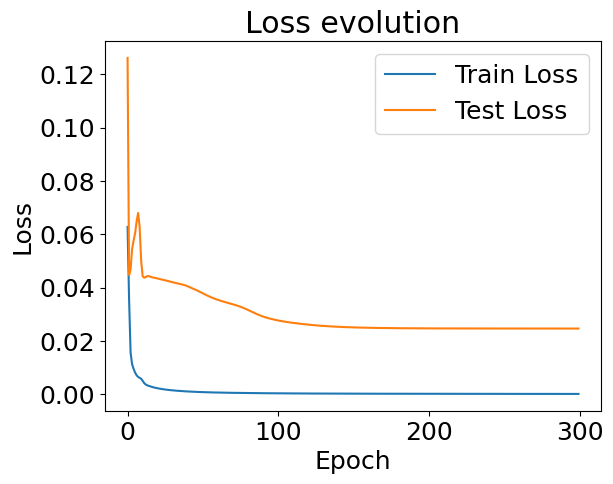

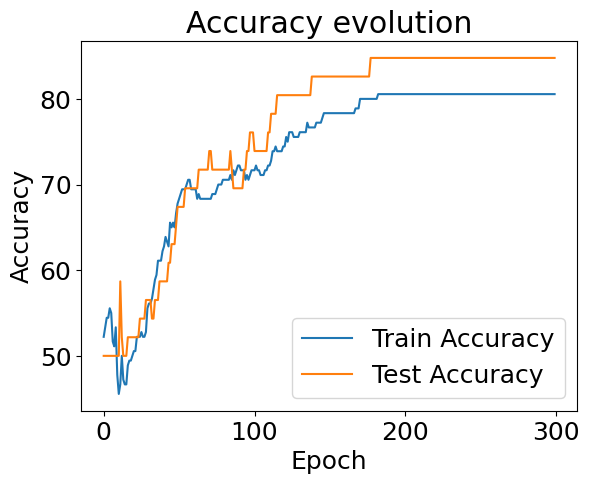

In [16]:
plot_loss(loss_list, test_loss_list, config['epochs'])
plot_accuracy(acc_list, test_acc_list, config['epochs'])
